### Program written by Pablo Sánchez-Palencia, 2022
Built-up on the basis of the code previously written by Scott Midgley

Scope: To run LR model for band gap and mixing energy screening in the configurational space of Sn2GeN4 spinel solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Windows path
repodir = r'C:\Users\pablo\OneDrive\Documentos\GitHub\GeSn2N4-ML'

# Define percentage of training data to use for training. 
#split = 20
#split = 50
split = 80

# Define the structural descriptor to use as input for the model
#descriptor="Coulomb_mm"
#descriptor="Coulomb_ds"
#descriptor="Sine_mm"
#descriptor="Sine_ds"
#descriptor="Ewald_mm"
#descriptor="Ewald_ds"
#descriptor="MBTR"
descriptor="CorrM"

#Define property to predict with the model
#feature="SCF"
feature="MixE";labelsname="Mixing Energy"
#feature="BGE";labelsname="Bandgap"
#feature="HSE-corr";labelsname="Bandgap"

#Define model of linear regression. You can also change the regularization coefficient
#method="linear"
method="lasso";alpha=0.000000000001
#method="ridge";alpha=0.001

In [2]:
# Import modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import shap
import sklearn
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge

## Load the data

In [3]:
# Import data and shuffle (optional).
ener = pd.read_pickle(repodir + '\\descriptors\\input_data_cm.pkl')
sm_data = pd.read_pickle(repodir + '\\descriptors\\input_data_sm.pkl')
em_data = pd.read_pickle(repodir + '\\descriptors\\input_data_em.pkl')
mbtr_data = pd.read_pickle(repodir + '\\descriptors\\input_data_mbtr.pkl')

ener["Sine_ds"]=sm_data["Sine_ds"]
ener["Sine_mm"]=sm_data["Sine_mm"]
ener["Ewald_ds"]=em_data["Ewald_ds"]
ener["Ewald_mm"]=em_data["Ewald_mm"]
ener["MBTR"]=mbtr_data["MBTR"]

ener = ener.sample(frac=1,random_state=91)

In [4]:
# Split data frame into training, validation, and testing data. 
l=len(ener)

e_test = ener.iloc[:l//10+1] #10% of data for testing model
e_val = ener.iloc[l//10+1:l//10*2+1] #10% of data for validation

if split == int(20):
    e_train = ener.iloc[l//10*2+1:l//10*4+1] #30% of data for training
elif split == int(50):
    e_train = ener.iloc[l//10*2+1:l//10*7+1] #50% of data for training
elif split == int(80):
    e_train = ener.iloc[l//10*2+1:l] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')

In [5]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train[descriptor].to_numpy()
Xtrain = np.stack(Xtrain)
Xval   = e_val[descriptor].to_numpy()
Xval   = np.stack(Xval)
Xtest  = e_test[descriptor].to_numpy()
Xtest  = np.stack(Xtest)
ytrain = e_train[feature].to_numpy()
yval   = e_val[feature].to_numpy()
ytest  = e_test[feature].to_numpy()
itrain = e_train['tag'].to_numpy()
ival   = e_val['tag'].to_numpy()
itest  = e_test['tag'].to_numpy()

Number of training data points =  810


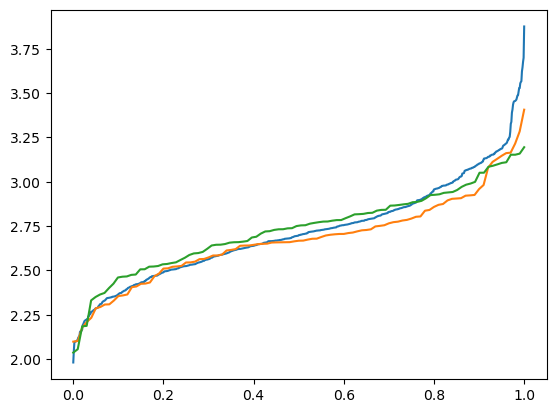

In [6]:
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

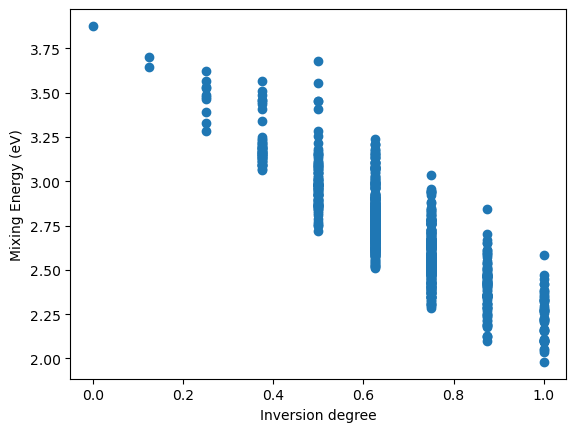

In [7]:
plt.figure()
plt.plot(ener['inv'],ener[feature],'o')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

## Train a model from scrach 

In [8]:
if method=="linear":
    model = LinearRegression()
elif method=="lasso":
    model = Lasso(alpha)
elif method=="ridge":
    model = Ridge(alpha)
else:
    model = LinearRegression()
    print("WARNING: Linear Regression method not selected")

model.fit(Xtrain, ytrain)

Lasso(alpha=1e-12)

In [9]:
# Print parameters.
r_sq = (model.score(Xtrain, ytrain))
inter = ('intercept: ', model.intercept_)
coef = ('coefficient:  ', model.coef_)
print(r_sq)
print(inter)
print(coef)

0.9997691410912649
('intercept: ', 4.004138530648238)
('coefficient:  ', array([-2.21028792e-01,  0.00000000e+00,  3.16320225e-03,  5.09420122e-04,
       -1.19277890e-02, -2.10221573e-02, -2.53739405e-02,  4.00343508e-02,
        4.92744464e-02,  2.50340400e-03, -6.30001605e-03, -3.60753151e-03,
       -4.99212632e-03, -1.25467221e-02, -1.96706322e-03, -4.08164611e-03,
       -4.22224282e-03, -3.00148308e-03,  7.02481444e-03, -4.36905008e-03,
       -1.35342364e-02, -9.46902127e-03, -7.59030010e-05, -4.18849982e-03,
        2.49023396e-02,  1.16498715e-02, -1.72903597e-03,  8.33695191e-03,
        1.09243982e-02, -1.45043261e-03,  2.13833742e-02, -1.44180175e-02,
        7.51369211e-03, -3.26731764e-03]))


In [10]:
# Test linear regressor.
ypred = model.predict(Xtest)

In [11]:
mae = mean_absolute_error(ytest, ypred)
maxerr=max(abs(ypred.reshape(l//10+1,)-ytest))
r2=r2_score(ytest,ypred)

print('Mean absolute error {} ev'.format(mae))
print('Maximum absolute error {} ev'.format(maxerr))
print('R2 coefficient {}'.format(r2))

Mean absolute error 0.0033569936500510737 ev
Maximum absolute error 0.01564077548401066 ev
R2 coefficient 0.9996720995222582


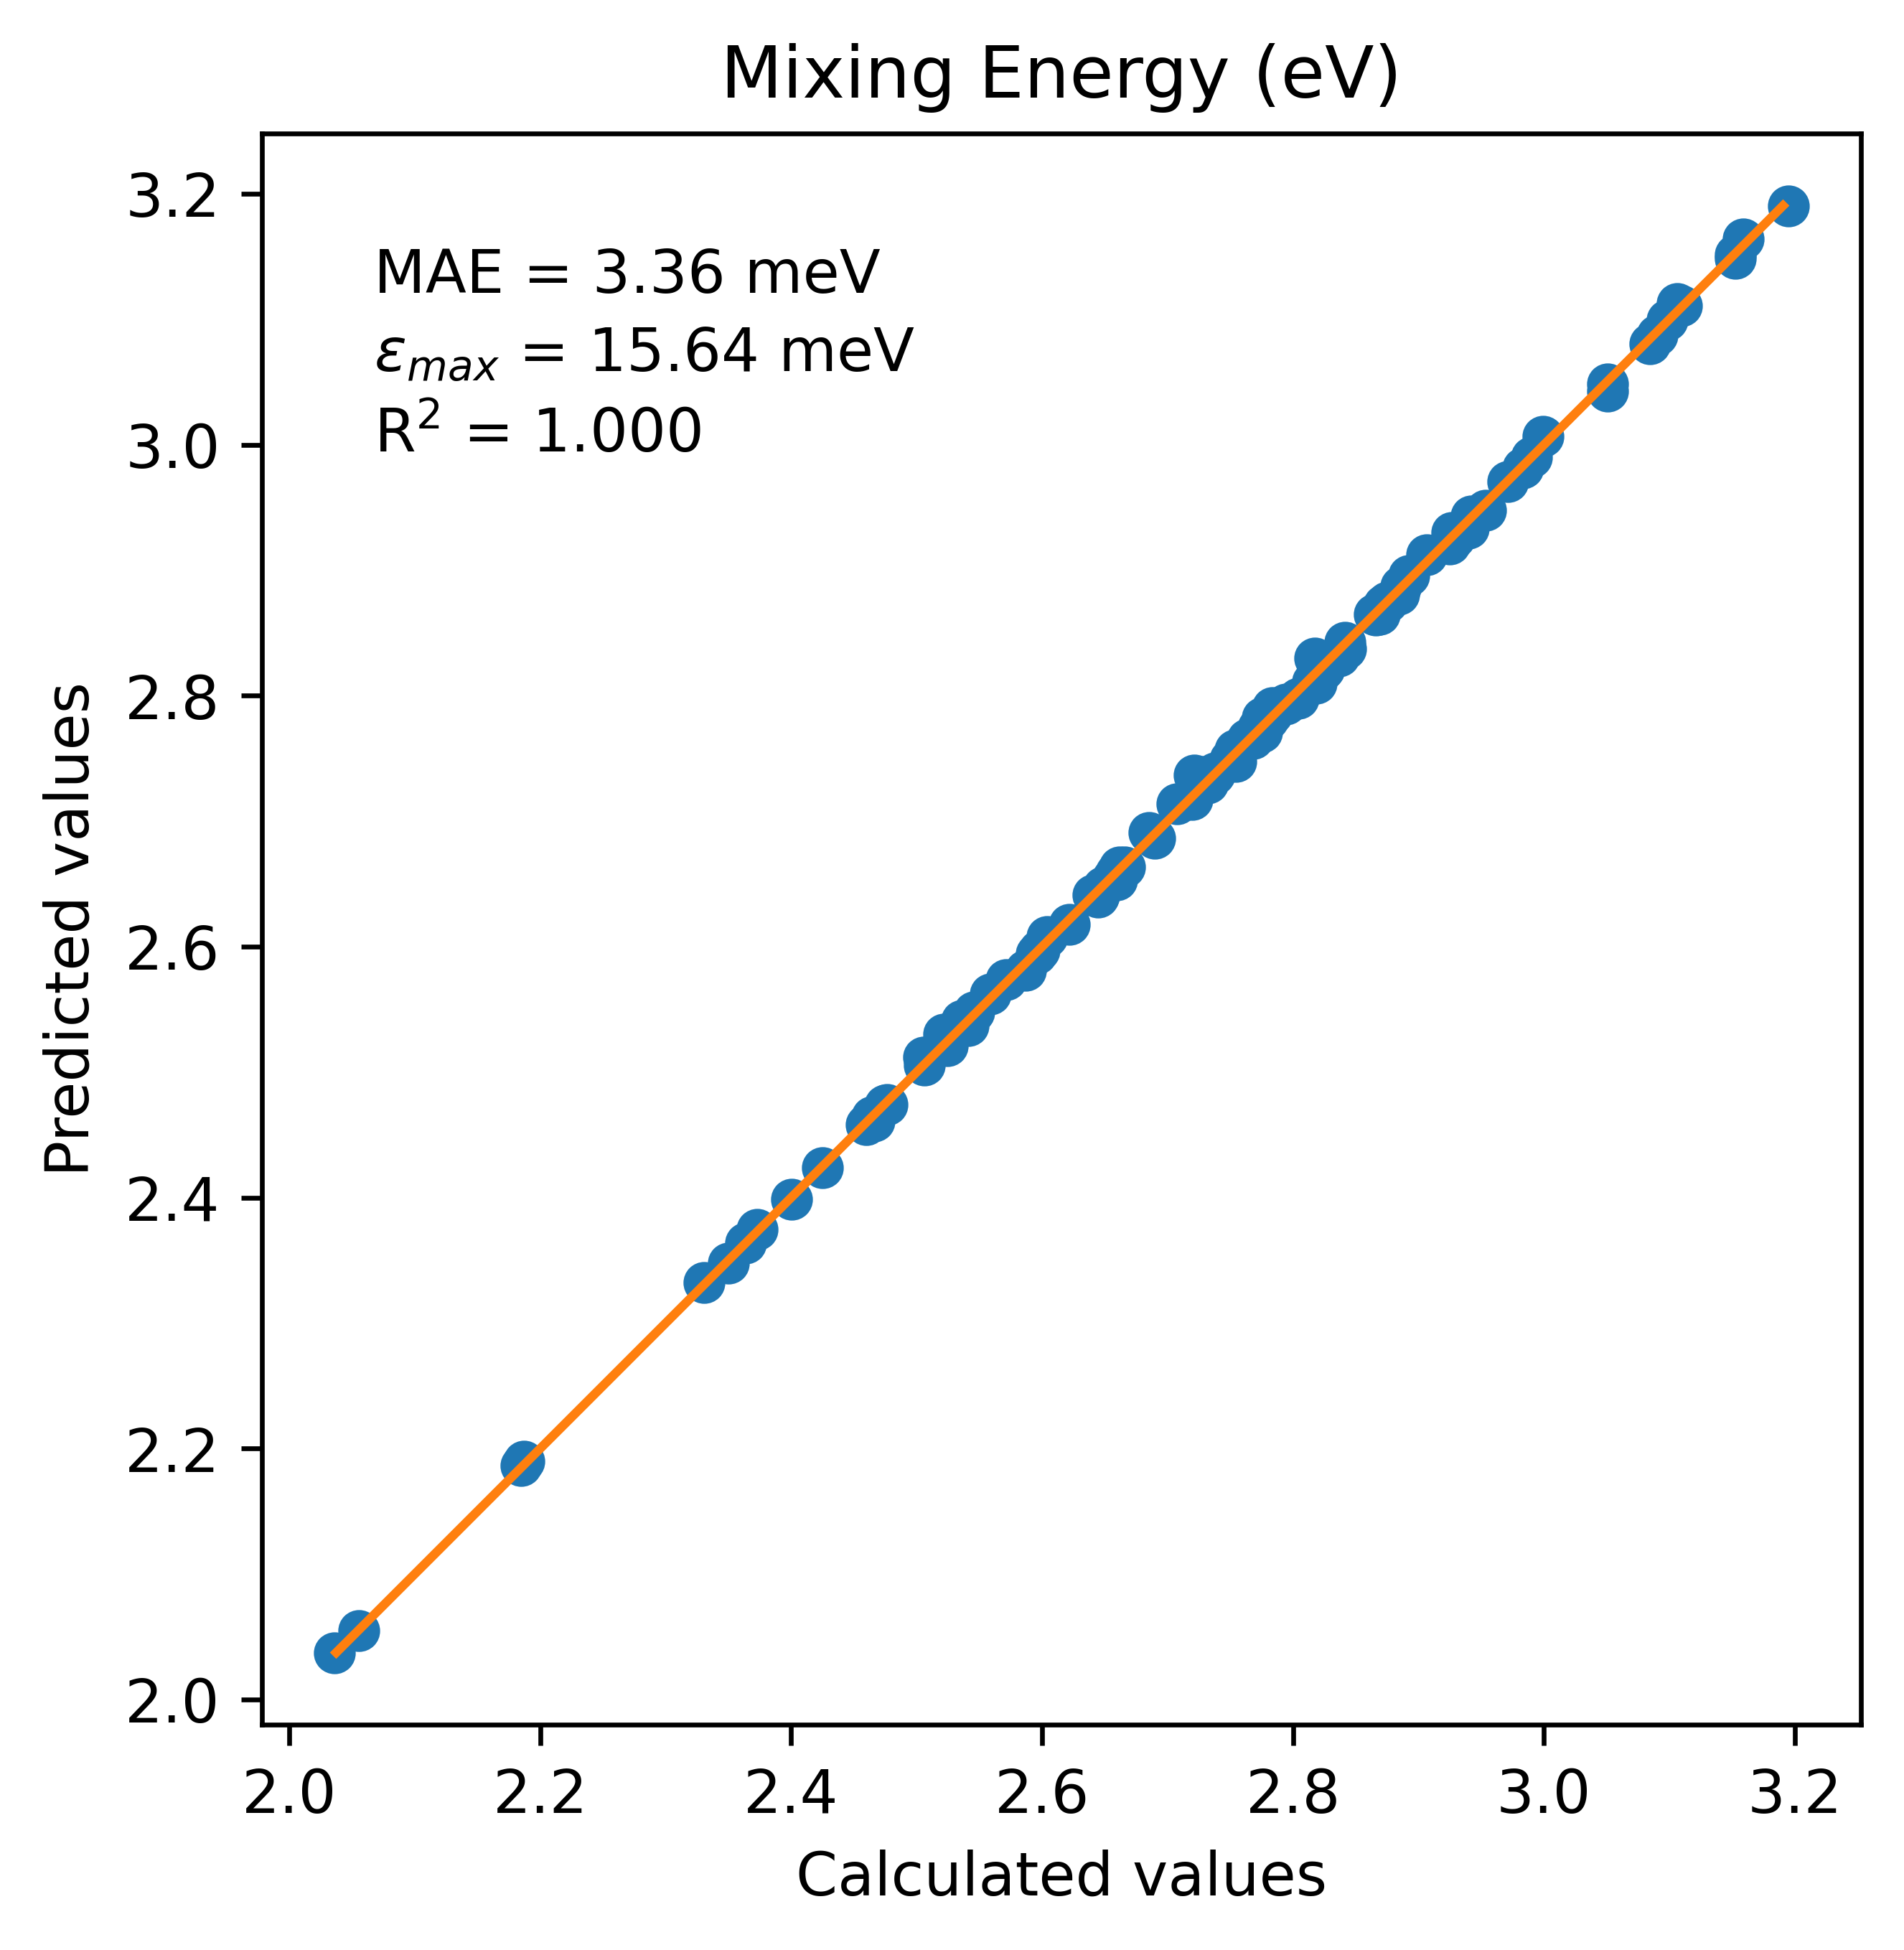

In [12]:
plt.figure(dpi=600)
plt.plot(ytest.reshape(l//10+1,),ypred,'o')
eje=np.linspace(min(ypred),max(ypred),10)
plt.plot(eje,eje)
plt.title(labelsname+" (eV)")
#plt.ylabel("Predicted "+labelsname)
#plt.xlabel("Calculated "+labelsname)
plt.ylabel("Predicted values")
plt.xlabel("Calculated values")
#plt.savefig(feature+comp+'-'+descriptor+'-'+method+'preds.png')
ax=plt.gca()
ax.set_aspect('equal', adjustable='box')
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
xtags=xmin+0.07*(xmax-xmin)
yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
ytags=ymin+yperc*(ymax-ymin)
plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae*1000) +" meV")
plt.text(xtags,ytags[1], r'$\epsilon$$_{max}$ = '+'%.2f' % (maxerr*1000) +" meV")
plt.text(xtags,ytags[2], r'R$^2$ = '+'%.3f' % r2)
plt.show()
plt.close()

In [13]:
trainpred = model.predict(Xtrain)
mae = mean_absolute_error(ytrain, trainpred)
r2=r2_score(ytrain,trainpred)
print('Mean absolute error {} ev'.format(mae))
print('Maximum error {} ev'.format(max(abs(trainpred.reshape(len(trainpred),)-ytrain))))
print('R2 = {}'.format(r2))

Mean absolute error 0.003353598333807063 ev
Maximum error 0.018704921157024934 ev
R2 = 0.9997691410912649


In [14]:
valpred = model.predict(Xval)
mae = mean_absolute_error(yval, valpred)
r2=r2_score(yval,valpred)
print('Mean absolute error {} ev'.format(mae))
print('Maximum error {} ev'.format(max(abs(valpred.reshape(len(valpred),)-yval))))
print('R2 = {}'.format(r2))

Mean absolute error 0.0029840245598361987 ev
Maximum error 0.011460633452745839 ev
R2 = 0.9997553475721461


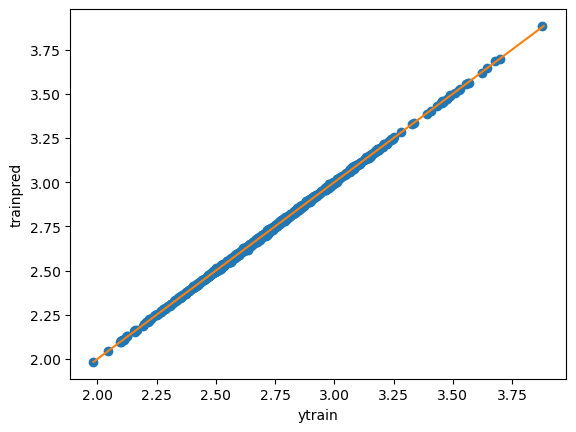

In [15]:
plt.figure()
plt.plot(ytrain.reshape(len(trainpred),),trainpred,'o')
eje=np.linspace(min(trainpred),max(trainpred),10)
plt.plot(eje,eje)
plt.ylabel("trainpred")
plt.xlabel("ytrain")
plt.show()
plt.close()

## SHAP analysis + linear coefficients

In [16]:
feature_labels=["Cluster 1 (k=1,l=0)","Cluster 2 (k=1,l=0)","Cluster 3 (k=2,l=3.130)",
                "Cluster 4 (k=2,l=3.670)","Cluster 5 (k=2,l=3.833)","Cluster 6 (k=2,l=5.421)",
                "Cluster 7 (k=2,l=5.750)","Cluster 8 (k=2,l=6.260)","Cluster 9 (k=2,l=6.260)",
                "Cluster 10 (k=3,l=3.130)","Cluster 11 (k=3,l=3.670)","Cluster 12 (k=3,l=3.670)",
                "Cluster 13 (k=3,l=3.833)","Cluster 14 (k=3,l=5.421)","Cluster 15 (k=3,l=5.421)",
                "Cluster 16 (k=3,l=5.421)","Cluster 17 (k=3,l=5.421)","Cluster 18 (k=3,l=5.750)",
                "Cluster 19 (k=3,l=5.750)","Cluster 20 (k=3,l=5.750)","Cluster 21 (k=3,l=5.750)",
                "Cluster 22 (k=3,l=5.750)","Cluster 23 (k=3,l=6.260)","Cluster 24 (k=3,l=6.260)",
                "Cluster 25 (k=3,l=6.260)","Cluster 26 (k=3,l=6.260)","Cluster 27 (k=3,l=6.260)",
                "Cluster 28 (k=3,l=6.260)","Cluster 29 (k=3,l=6.260)","Cluster 30 (k=3,l=6.260)",
                "Cluster 31 (k=3,l=6.260)","Cluster 32 (k=3,l=6.260)","Cluster 33 (k=3,l=7.257)",
                "Cluster 34 (k=3,l=7.340)"]

In [17]:
explainer = shap.Explainer(model, Xtrain,feature_names=feature_labels)
shap_values = explainer(Xtest)

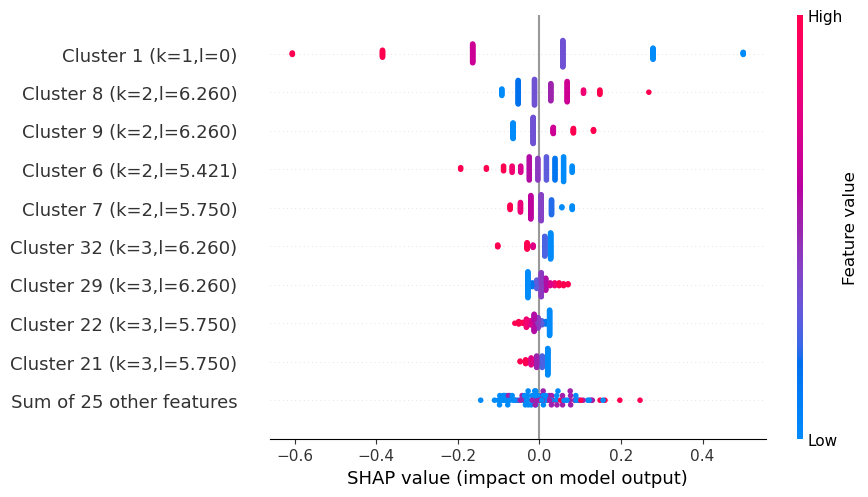

In [18]:
shap.plots.beeswarm(shap_values)

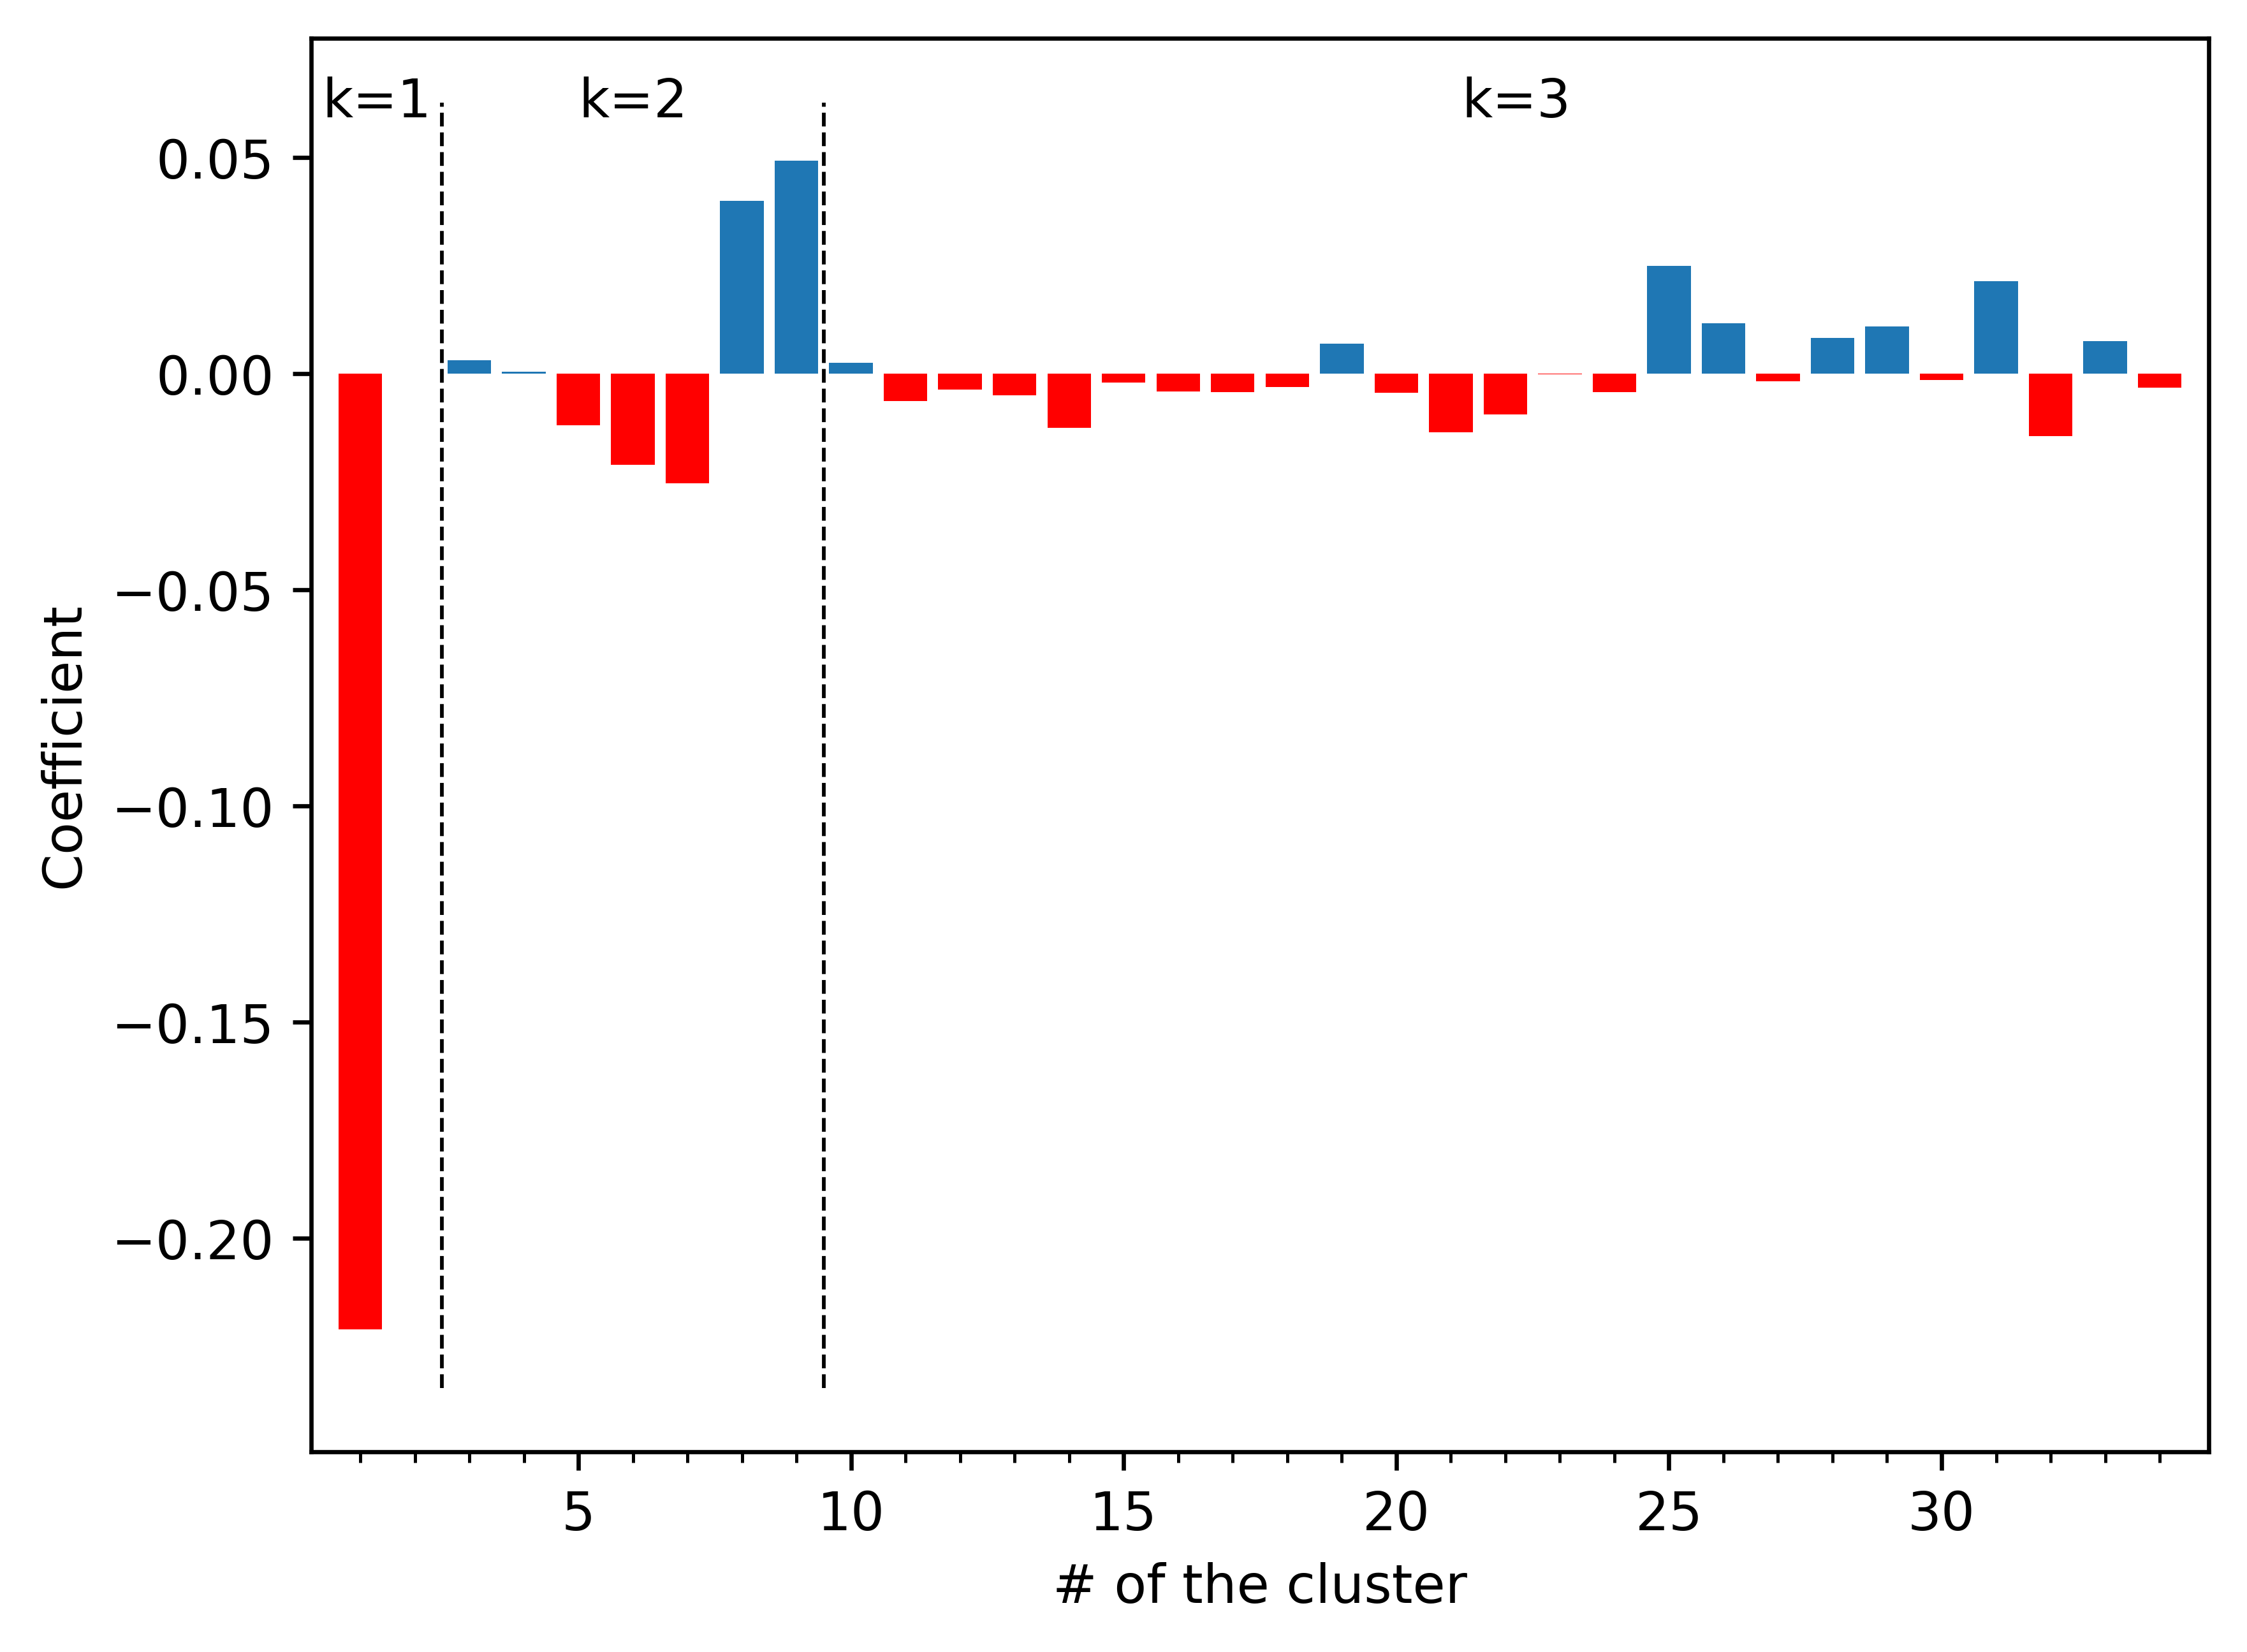

In [19]:
plt.figure(dpi=600)
xneg=[];xpos=[];coefneg=[];coefpos=[]
xval=np.linspace(1,34,34)
for val,cc in zip(xval,coef[1]):
    if cc>=0:
        xpos.append(val)
        coefpos.append(cc)
    elif cc<0:
        xneg.append(val)
        coefneg.append(cc)
plt.bar(xpos,coefpos)
plt.bar(xneg,coefneg,color="red")
ax=plt.gca()
ax.set_xticks([5,10,15,20,25,30])
ax.set_xticks(xval,minor=True)
plt.xlim([0.1,34.9])
ymin,ymax=ax.get_ylim()
plt.plot(np.linspace(2.5,2.5,20),np.linspace(ymin,ymax,20),"k--",linewidth=0.7)
plt.plot(np.linspace(9.5,9.5,20),np.linspace(ymin,ymax,20),"k--",linewidth=0.7)
plt.text(0.1+(2.5-0.1)/2,ymax,"k=1",ha="center",va="center")
plt.text(2.5+(9.5-2.5)/2,ymax,"k=2",ha="center",va="center")
plt.text(9.5+(34.9-9.5)/2,ymax,"k=3",ha="center",va="center")
plt.xlabel("# of the cluster")
plt.ylabel("Coefficient")
plt.show()
plt.close()

## Covariance matrix 

Some extra insight of the CCF is taken from the covariance matrix of the different clusters.

In [20]:
def normalize(X):
    """Normalize the given dataset X to have zero mean.
    Args:
        X: ndarray, dataset of shape (N,D)
    
    Returns:
        (Xbar, mean): tuple of ndarray, Xbar is the normalized dataset
        with mean 0; mean is the sample mean of the dataset.
    """
    N, D = X.shape
    mu = np.mean(X,axis=0)
    std= np.std(X,axis=0)
    #std[std==0]=1
    Xbar=(X-mu)
    return Xbar, mu,std

In [21]:
X_normalized, mean,std = normalize(np.vstack(ener["CorrM"].to_numpy()))
M = np.dot(X_normalized.T, X_normalized) / X_normalized.shape[0]
std=std[np.newaxis]
M_n=M/np.dot(std.T,std)

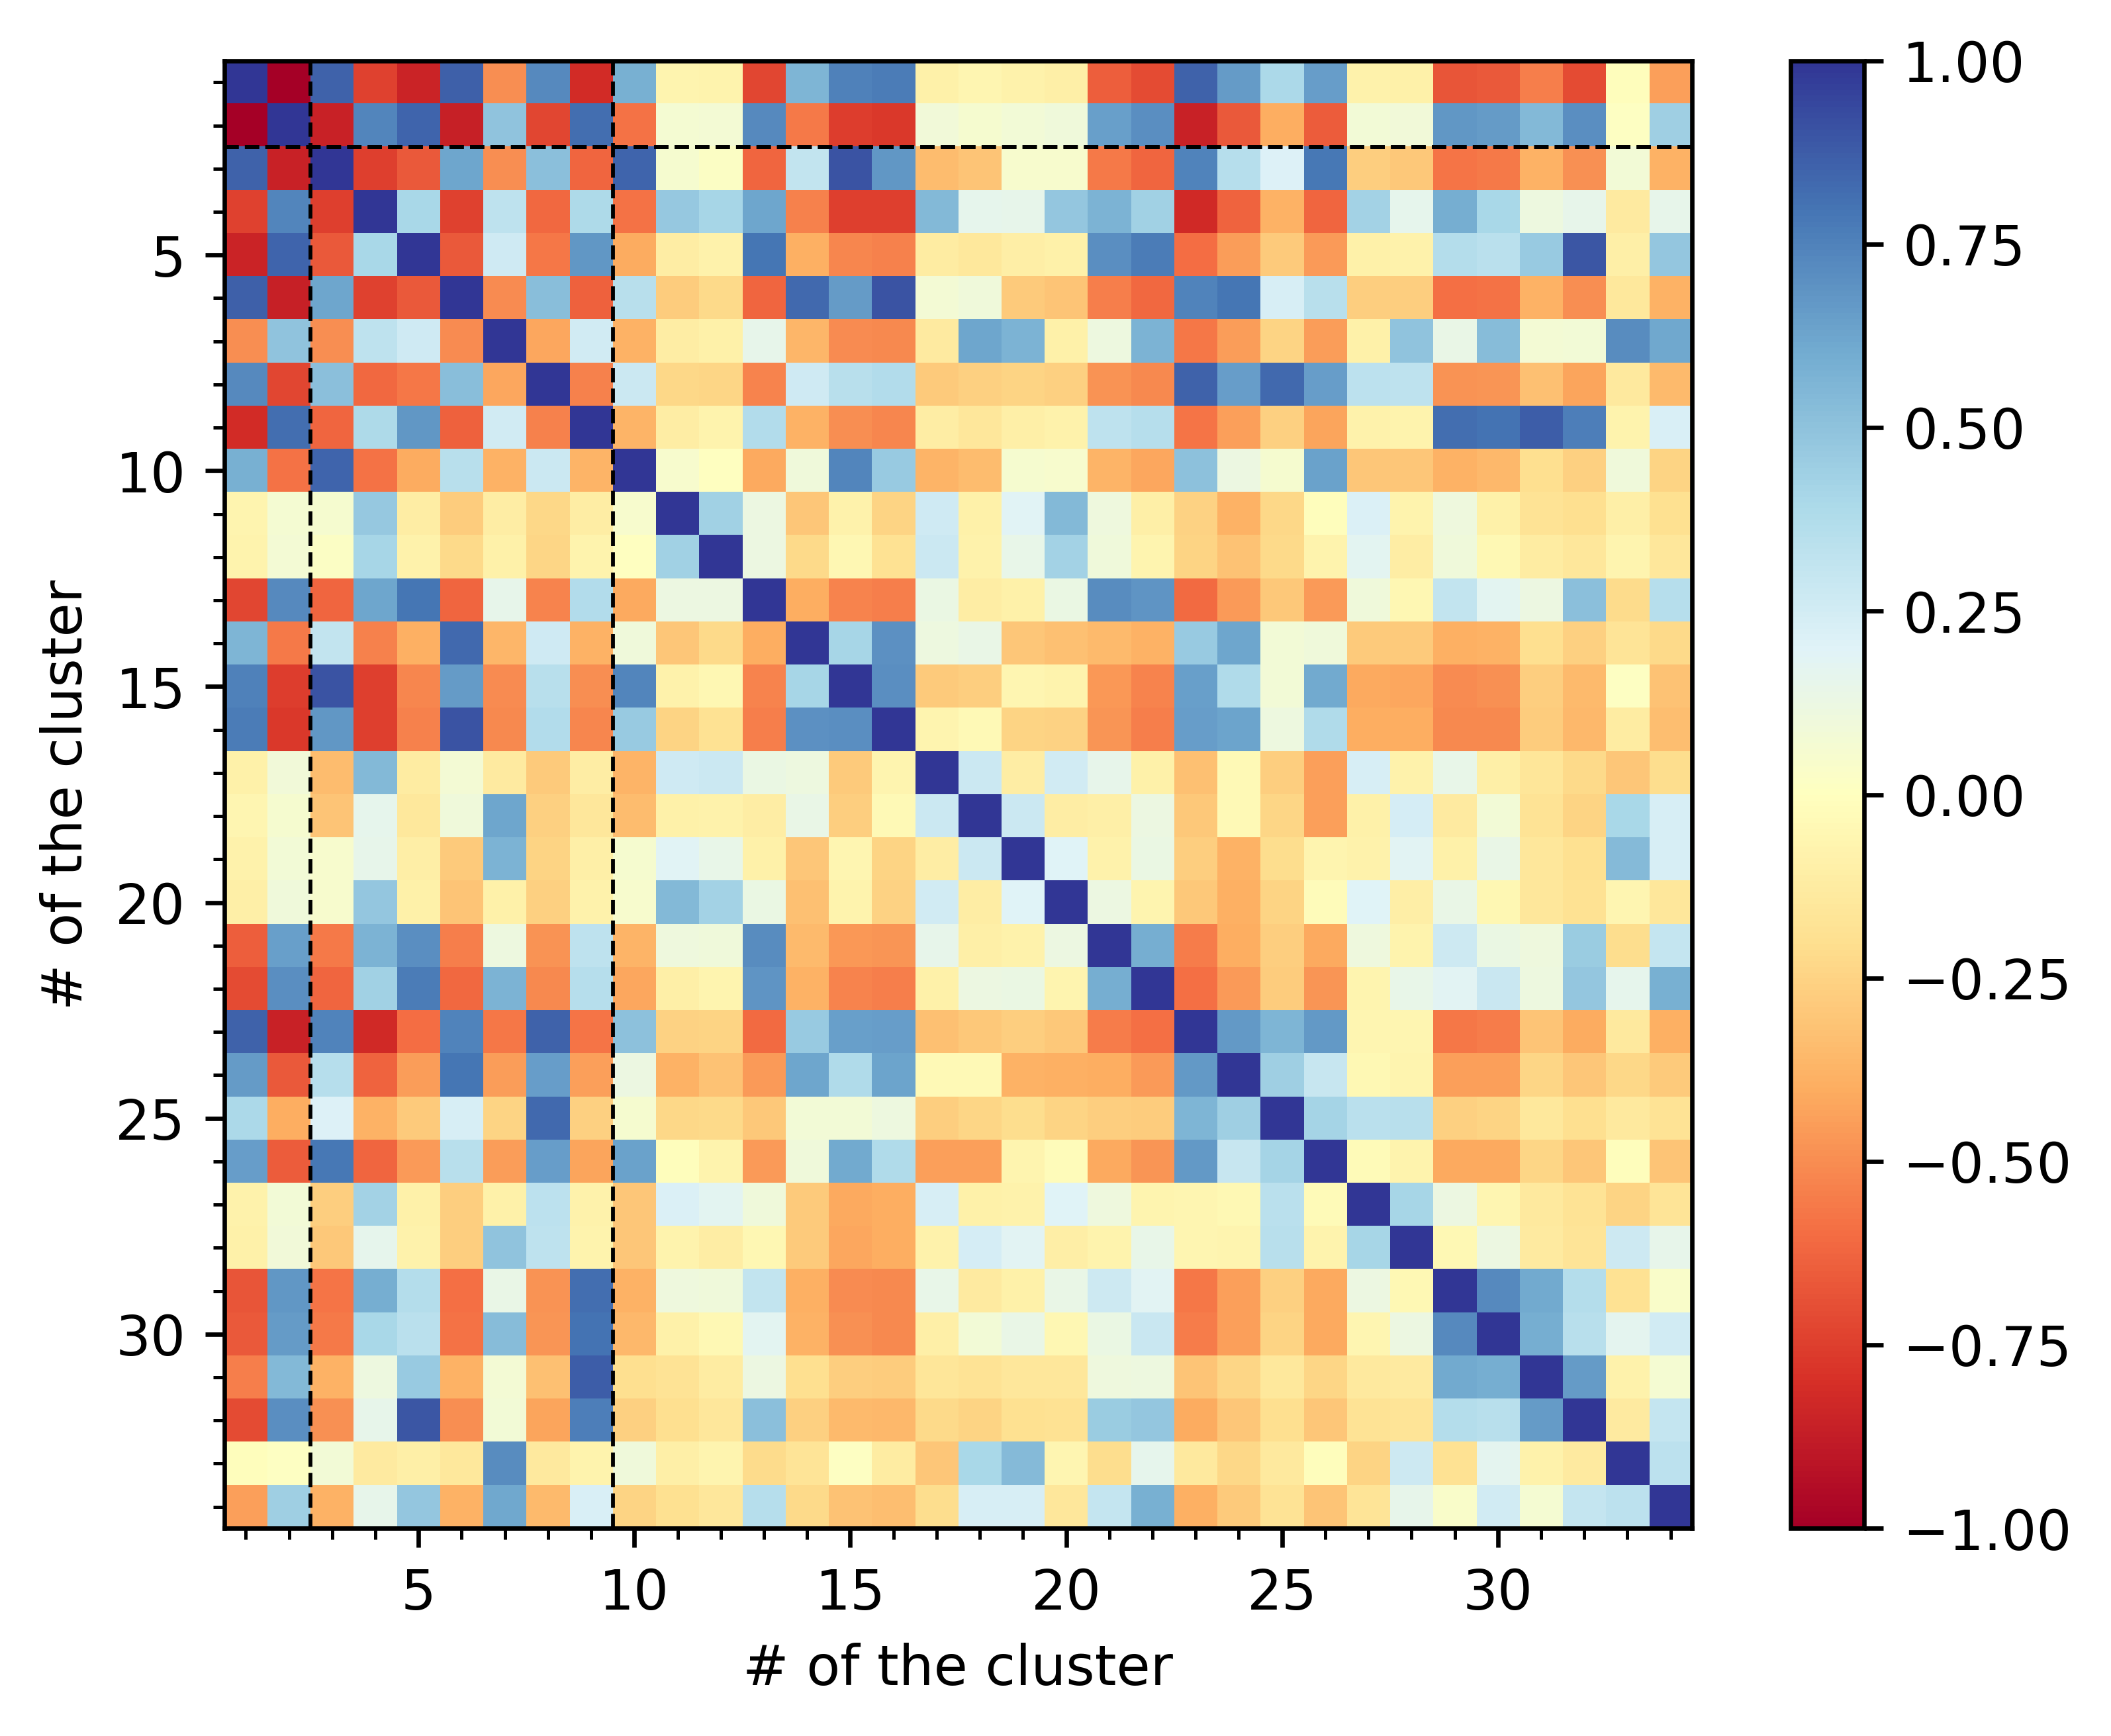

In [22]:
plt.figure(dpi=600)
plt.imshow(M_n,interpolation='nearest',cmap=plt.get_cmap("RdYlBu"))
ax=plt.gca()
ax.set_xticks([4,9,14,19,24,29])
ax.set_xticks(np.linspace(0,33,34),minor=True)
ax.set_xticklabels(["5","10","15","20","25","30"])
ax.set_yticks([4,9,14,19,24,29])
ax.set_yticks(np.linspace(0,33,34),minor=True)
ax.set_yticklabels(["5","10","15","20","25","30"])
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()
plt.plot(np.linspace(1.5,1.5,20),np.linspace(ymin,ymax,20),"k--",linewidth=0.7)
plt.plot(np.linspace(8.5,8.5,20),np.linspace(ymin,ymax,20),"k--",linewidth=0.7)
plt.plot(np.linspace(xmin,xmax,20),np.linspace(1.5,1.5,20),"k--",linewidth=0.7)
plt.plot(np.linspace(xmin,xmax,20),np.linspace(1.5,1.5,20),"k--",linewidth=0.7)
plt.xlabel("# of the cluster")
plt.ylabel("# of the cluster")
plt.colorbar()
plt.show()

## Model predictions 

Here you can make predictions for the selected feature/property with the model previously trained for all the structures in an specific composition rate or for the whole compositional space (be coherent with the training space and the predicted space).

In [23]:
#Read input for all the structures
allstr = pd.read_pickle(repodir + '\\descriptors\\correlationmatrix_allstr\\str_corrm.pkl')

In [24]:
#Predict property for all the structures and save predictions in the dataframe
all_pred = model.predict(np.stack(allstr["CorrM"].to_numpy()))
allstr[feature+'_pred']=all_pred
allstr[feature+'_dev']=abs(all_pred-np.stack(allstr[feature].to_numpy()))

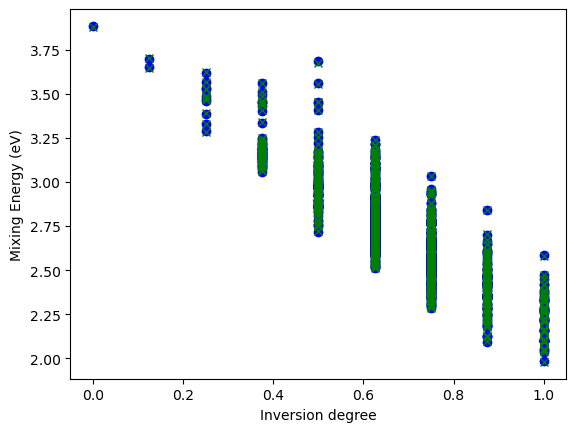

In [25]:
plt.figure()
#plt.plot(allstr['y'],allstr[feature+'_pred'],'bo')
plt.plot(allstr[allstr['gga_data']==True]['y'],allstr[allstr['gga_data']==True][feature+'_pred'],'bo')
#plt.plot(allstr[allstr['gga_data']==False]['y'],allstr[allstr['gga_data']==False][feature+'_pred'],'ro')
plt.plot(ener['inv'],ener[feature],'gx')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

In [26]:
# Save data frame to different format files.
#allstr.to_pickle(repodir + '\\descriptors\\correlationmatrix_allstr\\'+comp+'str_corrm.pkl')

In [27]:
#Unless the .pkl file is already loaded with Bandgap predictions from the MLP model this code will prompt an error 
plt.figure()
plt.plot(allstr["MixE_pred"],allstr["HSE-corr_ens-meanpred"],'bo')
#plt.plot(allstr[allstr['gga_data']==True]['y'],allstr[allstr['gga_data']==True][feature+'_pred'],'bo')
#plt.plot(allstr[allstr['gga_data']==False]['y'],allstr[allstr['gga_data']==False][feature+'_pred'],'ro')
#plt.plot(ener['inv'],ener[feature],'gx')
plt.xlabel("Mixing energy (eV)")
plt.ylabel("Bandgaps (eV)")
#plt.savefig('dist'+feature+comp+".png")
plt.show()
plt.close()

KeyError: 'HSE-corr_ens-meanpred'